In [19]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt

device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cpu device


In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder

# Cargar los datos
data = pd.read_csv('data.csv')
data = data[data['Modelo'] == 'SW4']

# A la columna de Kilómetros le sacamos el km y lo convertimos a número
data['Kilómetros'] = data['Kilómetros'].str.replace(' km', '').str.replace(',', '').astype(int)
# Definir las características (features) y el objetivo (target)
X = data[['Kilómetros', 'Edad']]
y = data['Precio']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_max = X_train.max()
X_train_min = X_train.min()
X_test = (X_test - X_train_min) / (X_train_max - X_train_min)
X_train = (X_train - X_train_min) / (X_train_max - X_train_min)
y_train_max = y_train.max()
y_test = y_test / y_train.max()
y_train = y_train / y_train.max()

# Convertir las características a tensores
X_train = torch.tensor(X_train.values).float()
y_train = torch.tensor(y_train.values).float()

X_test = torch.tensor(X_test.values).float()
y_test = torch.tensor(y_test.values).float()

# Definir el tamaño del lote
batch_size = 64

# Crear un DataLoader para los datos de entrenamiento
train_data = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

# Crear un DataLoader para los datos de prueba
test_data = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

# Definir la arquitectura de la red neuronal
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.model = nn.Sequential(
            # nn.Linear(3, 64),
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            # nn.Linear(64, 128),
            # nn.ReLU(),
            # nn.Linear(128, 64),
            # nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(64, 1)
            # nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)
    

Epoch 1/100, Train Loss: 0.12117221889396508, Test Loss: 0.10091221829255421
Epoch 2/100, Train Loss: 0.10232735176881154, Test Loss: 0.08402989059686661
Epoch 3/100, Train Loss: 0.08578870569666226, Test Loss: 0.0694881056745847
Epoch 4/100, Train Loss: 0.07147847892095645, Test Loss: 0.05691629648208618
Epoch 5/100, Train Loss: 0.05937695782631636, Test Loss: 0.04611171409487724
Epoch 6/100, Train Loss: 0.04888150996218125, Test Loss: 0.037394799292087555
Epoch 7/100, Train Loss: 0.040336984830598034, Test Loss: 0.03030112013220787
Epoch 8/100, Train Loss: 0.033440893360724054, Test Loss: 0.024557096262772877
Epoch 9/100, Train Loss: 0.02784068261583646, Test Loss: 0.020247720802823704
Epoch 10/100, Train Loss: 0.023567048211892445, Test Loss: 0.01712218640993039
Epoch 11/100, Train Loss: 0.020493904361501336, Test Loss: 0.014796968239049116
Epoch 12/100, Train Loss: 0.018012070329859853, Test Loss: 0.013142720175286135
Epoch 13/100, Train Loss: 0.016177936922758818, Test Loss: 0.011

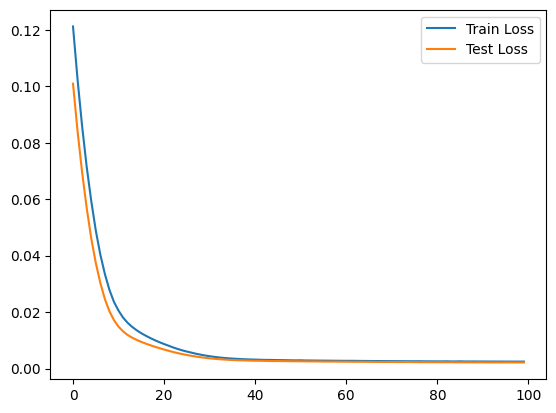

In [21]:
# Crear una instancia de la red neuronal
model = NeuralNetwork().to(device)

# Definir la función de pérdida y el optimizador
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Entrenar la red neuronal
num_epochs = 100
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))

    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch.unsqueeze(1))
            test_loss += loss.item()
        test_losses.append(test_loss / len(test_loader))

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]}, Test Loss: {test_losses[-1]}")

# Visualizar la pérdida durante el entrenamiento
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.show()

In [22]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test.to(device))
    loss = criterion(y_pred, y_test.unsqueeze(1).to(device))
    print(f"Test Loss: {loss.item()}")
    print(f"Error: {loss.item() * y_train_max}")

Test Loss: 0.002137339673936367
Error: 218.00864674150944


In [34]:
X_new = pd.DataFrame({
    'Kilómetros': [150000],
    'Edad': [7],
})
X_new = (X_new - X_train_min) / (X_train_max - X_train_min)
X_new = torch.tensor(X_new.values).float().to(device)
y_pred = model(X_new)
y_pred = y_pred.item() * y_train_max
print(f"El precio estimado del coche es: {y_pred:.2f} €")

El precio estimado del coche es: 33864.21 €


In [35]:
X_new = pd.DataFrame({
    'Kilómetros': [500000],
    'Edad': [15],
})
X_new = (X_new - X_train_min) / (X_train_max - X_train_min)
X_new = torch.tensor(X_new.values).float().to(device)
y_pred = model(X_new)
y_pred = y_pred.item() * y_train_max
print(f"El precio estimado del coche es: {y_pred:.2f} €")

El precio estimado del coche es: 17985.73 €


In [36]:
X_new = pd.DataFrame({
    'Kilómetros': [400000],
    'Edad': [18],
})
X_new = (X_new - X_train_min) / (X_train_max - X_train_min)
X_new = torch.tensor(X_new.values).float().to(device)
y_pred = model(X_new)
y_pred = y_pred.item() * y_train_max
print(f"El precio estimado del coche es: {y_pred:.2f} €")

El precio estimado del coche es: 15951.66 €
